This notebook is for testing portfolio creation methods   

Check does pyportfolio opt use yearly returns   
drop any which have negative returns   

we have a problem which creeps in as we increase the # of input columns investigationg if this is due to anomalies in some columns of is just a result of taking in so many columns.
- *The covariance matrix is non positive semidefinite. Amending eigenvalues. Could not fix matrix. Please try a different risk model.*
- Issue is around rows to column ratio see issue on [PyPortfolioOpt #263](https://github.com/robertmartin8/PyPortfolioOpt/issues/263)



Currently working on a function that calculates an optimal sharpe portfolio & tests its performance on the following year(always test on a 1 year period but can use multiple years of data for input)   

**Inputs:**
- closing price Database *DataFrame*
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*  

**Outputs** (Array)
- startdate *yyyy-mm-dd*
- enddate *yyyy-mm-dd*
- NOT RELEVANT years of input data (ie Years(enddate-startdate)) *float*
- optimal portfolio Expected performance *float*
- optimal portfolio Actual performance *float*
- performance of the market (ie total change of the input markets value over the test year) *float*



## Function ready now to make parameter tuning easier by making optional inputs for , n_rows , max_price, objective function etc...


In [1]:
#Import the libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import math
from datetime import timedelta 
import operator
from functools import reduce
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import plotting
import cvxpy as cp
from joblib import Parallel, delayed
import seaborn as sns
pd.options.mode.chained_assignment = None #silences setting with a copy warning
import DatabaseMainFnc as dmf
pd.set_option('display.max_columns', 38)
plt.rcParams['figure.figsize'] = [10, 10]


In [2]:
dmf.net_gains(3000,0.70,5,people=2)

30285.1081406409

In [3]:
%%time
df_Nasdaq=dmf.connectAndLoadDb('NASDAQ')
df_Nasdaq=df_Nasdaq.set_index(pd.DatetimeIndex(df_Nasdaq['Date'].values))
df_Nasdaq.drop(columns=['Date'],axis=1, inplace=True)

df_NYSE=dmf.connectAndLoadDb('NYSE')
df_NYSE=df_NYSE.set_index(pd.DatetimeIndex(df_NYSE['Date'].values))
df_NYSE.drop(columns=['Date'],axis=1, inplace=True)
df_Nasdaq.tail(10)

Connecting database:NASDAQ
Database connected!
Connecting database:NYSE
Database connected!
Wall time: 6.44 s


,AACG,AACQ,AACQU,AAL,AAME,AAOI,AAON,AAPL,AAWW,AAXJ,ABCB,ABCL,ABCM,ABEO,ABGI,ABIO,ABMD,ABNB,ABST,...,ZIONO,ZIONP,ZIOP,ZIXI,ZKIN,ZLAB,ZM,ZNGA,ZNTE,ZNTEU,ZNTEW,ZNTL,ZS,ZSAN,ZUMZ,ZVO,ZWRKU,ZYNE,ZYXI
2021-02-24,5.06,11.80,12.87,21.820000,4.53,11.610,77.879997,125.349998,59.090000,97.660004,50.240002,40.099998,22.459999,2.20,10.36,4.71,323.779999,200.199997,15.14,...,26.248926,25.000999,4.90,9.59,8.55,156.899994,385.230011,11.29,11.33,12.61,2.835,40.259998,207.809998,1.40,47.990002,6.21,10.590,5.010,18.42
2021-02-25,5.06,11.23,12.08,20.860001,4.63,11.170,76.629997,120.989998,56.070000,95.980003,48.119999,39.060001,22.850000,2.49,10.25,4.39,320.470001,182.059998,14.75,...,25.786001,25.058500,4.65,9.26,7.40,147.389999,364.730011,11.04,10.94,12.14,2.750,40.410000,195.789993,1.30,46.520000,5.52,10.460,4.460,17.42
2021-02-26,5.05,10.88,11.92,20.940001,4.47,9.325,77.099998,121.260002,55.130001,94.650002,47.639999,37.709999,23.830000,2.42,10.26,4.21,324.549988,206.350006,15.19,...,26.120001,24.559999,5.33,7.38,6.01,147.520004,373.609985,11.15,10.89,11.96,2.635,42.040001,205.029999,1.28,45.080002,5.13,10.410,4.495,14.52
2021-03-01,5.15,11.23,12.01,21.180000,4.76,9.020,77.379997,127.790001,55.320000,97.339996,49.020000,39.689999,22.590000,2.34,10.25,4.37,324.260010,196.419998,15.60,...,26.080000,24.832500,5.26,7.42,7.44,162.020004,409.660004,11.56,10.96,12.14,2.710,41.730000,210.160004,1.33,47.060001,5.19,10.330,4.660,14.69
2021-03-02,5.07,10.73,11.51,21.440001,4.70,8.625,74.919998,125.120003,56.570000,95.930000,48.970001,38.000000,22.920000,2.36,10.14,4.52,325.309998,189.899994,15.66,...,26.120001,24.910000,5.07,7.35,6.40,148.009995,372.790009,11.39,10.57,11.55,2.400,43.500000,202.610001,1.25,46.540001,5.29,10.150,4.680,14.25
2021-03-03,4.63,10.38,11.03,22.170000,4.43,8.360,74.089996,122.059998,57.189999,95.620003,50.160000,35.669998,22.209999,2.19,10.09,4.27,307.600006,180.399994,14.56,...,26.080000,24.934999,4.68,6.97,6.29,140.669998,341.570007,11.09,10.35,11.06,1.830,43.630001,187.830002,1.22,46.330002,5.09,10.025,4.510,14.25
2021-03-04,4.26,10.29,10.79,21.240000,3.65,7.990,72.070000,120.129997,55.139999,93.389999,49.860001,30.049999,21.129999,2.08,9.99,3.98,295.630005,180.229996,14.13,...,26.420000,25.110001,4.31,7.13,5.20,133.070007,343.089996,10.48,10.20,10.95,1.510,43.549999,180.899994,1.07,45.389999,4.61,10.000,4.090,14.54
2021-03-05,4.08,10.66,11.34,20.450001,3.67,8.045,72.800003,121.419998,57.650002,94.459999,50.349998,28.610001,21.110001,2.01,9.97,4.12,301.220001,179.809998,13.85,...,26.530001,24.760000,4.29,7.15,5.18,137.250000,337.429993,10.31,10.36,11.19,1.850,42.330002,175.369995,1.07,46.029999,4.72,10.200,4.150,14.75
2021-03-08,4.01,10.68,11.24,21.469999,3.55,7.760,73.150002,116.360001,57.360001,91.610001,51.650002,26.760000,19.700001,2.10,10.07,3.98,285.920013,180.809998,13.62,...,26.490000,24.900000,4.07,7.01,5.05,127.559998,310.929993,9.85,10.19,10.98,1.660,39.369999,167.839996,1.19,48.660000,4.91,10.155,4.140,16.24
2021-03-09,4.37,10.67,11.33,21.600000,3.80,8.450,73.750000,121.089996,58.599998,93.779999,51.619999,30.639999,20.809999,2.18,9.99,4.06,296.799988,183.110001,14.92,...,26.830000,24.969999,4.61,7.66,6.15,135.139999,342.109985,10.28,10.23,11.06,1.650,42.889999,181.429993,1.18,47.700001,5.18,10.350,4.540,17.57


In [38]:
def portfolio_generate_test(database,startdate,enddate,p_max=400, min_returns=0.01, s_asset=0, asset_len=50,  silent=True):
    if silent == False:
        print('Running for :'+str(startdate)+' to '+str(enddate))
    # Subset for date range
    df_input=database[startdate:enddate]
    if silent == False:
        print ("Initial number of stocks: "+str(len(df_input.columns)))

    #Check for stocks which are too expensive for us to buy & drop those
    p_now=database.iloc[-1,:]
    df_unaffordable=p_now[p_now>p_max] #we can set max price here maybe as an optional
    l_unaffordable=df_unaffordable.index.tolist()
    df_input.drop(columns=l_unaffordable, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Our max price is : €"+str(p_max))
        print ("Number of stocks to drop due being unnaffordble: "+str(len(l_unaffordable)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    # drop any columns with more than half or more Nas as the models dont like these
    half_length=int(len(df_input)*0.50)
    l_drop=df_input.columns[df_input.iloc[:half_length,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to NAs: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))

    # drop any columns with more  Nas for their last 5 rows as these have been delisted
    l_drop=df_input.columns[df_input.iloc[-5:,:].isna().all()].tolist()
    df_input.drop(columns=l_drop, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to being delisted: "+str(len(l_drop)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))


    #see which stocks have negative returns or low returns in the period & drop those
    df_pct=(df_input.iloc[-1,:].fillna(0) / df_input.iloc[0,:])
    df_pct=df_pct[df_pct<= (min_returns + 1)] #we can set minimum returns here maybe as an optional
    l_pct=df_pct.index.tolist()
    df_input.drop(columns=l_pct, inplace=True)
    if silent == False:
        print ("-----------------------------------------------------")
        print ("Number of stocks due to Negative returns: "+str(len(l_pct)))
        print ("Number of stocks remaining: "+str(len(df_input.columns)))
        print ("Number of days data: "+str(len(df_input)))
        print ("As default we will only keep the top 50 performing stocks when creating our portfolio(this can be varied using s_asset & asset_len)")

    #We will only keep the X best performing assets can make this an optional input
    e_asset=s_asset + asset_len
    df=df_input
    mu = expected_returns.mean_historical_return(df)
    top_stocks = mu.sort_values(ascending=False).index[s_asset:e_asset]
    df = df[top_stocks]

    #Calculate expected annulised returns & annual sample covariance matrix of the daily asset
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    # Optomise for maximal Sharpe ratio
    ef= EfficientFrontier(mu, S) #Create the Efficient Frontier Object

    #We can try a variety of objectives 
    weights = ef.max_sharpe()
    #weights = ef.min_volatility()
    #weights = ef.efficient_risk(target_volatility)
    #target_return=0.1
    #weights = ef.efficient_return(target_return)


    cl_weights= ef.clean_weights()
    #print(cl_weights)
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%")
        ef.portfolio_performance(verbose=True)
    expected_portfolio_returns=ef.portfolio_performance()[0]

    #calculates the actual performance date range work on this
    actual_startdate = pd.to_datetime(enddate) + pd.DateOffset(days=2)
    actual_enddate = pd.to_datetime(actual_startdate) + pd.DateOffset(years=1)

    df_actual=database[actual_startdate:actual_enddate]
    df_actual=df_actual[top_stocks]
    df_yoy=pd.DataFrame(df_actual.iloc[-1,:].fillna(0) / df_actual.iloc[0,:], columns=['yoy_perc'])
    df_yoy['weights']=cl_weights.values()
    df_yoy['weighted_perc']=df_yoy['weights']*df_yoy['yoy_perc']
    actual_returns=df_yoy['weighted_perc'].sum()-1
    if silent == False:
        print("-------------------------------------------------------------")
        print("Our portfolio performed at : " + str(np.round(actual_returns,3)*100)+"%")
    return [pd.to_datetime(startdate),pd.to_datetime(enddate),expected_portfolio_returns,actual_returns]

In [39]:
database=df_Nasdaq
startdate=pd.to_datetime("2010-01-01")
enddate=pd.to_datetime("2020-01-01")
portfolio_generate_test(database,startdate,enddate,p_max=250, min_returns=0.01, s_asset=0, asset_len=50, silent=False)

Running for :2010-01-01 00:00:00 to 2020-01-01 00:00:00
Initial number of stocks: 4019
-----------------------------------------------------
Our max price is : €250
Number of stocks to drop due being unnaffordble: 69
Number of stocks remaining: 3950
-----------------------------------------------------
Number of stocks due to NAs: 1907
Number of stocks remaining: 2043
-----------------------------------------------------
Number of stocks due to being delisted: 3
Number of stocks remaining: 2040
-----------------------------------------------------
Number of stocks due to Negative returns: 408
Number of stocks remaining: 1632
Number of days data: 2520
As default we will only keep the top 50 performing stocks when creating our portfolio(this can be varied using s_asset & asset_len)
-------------------------------------------------------------
Our Benchmark portfolio the S&P 500 has: Volatility  18.1% & Annual Return: 10.6%
Expected annual return: 42.4%
Annual volatility: 16.7%
Sharpe Rat

[Timestamp('2010-01-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 0.42400884896928986,
 0.1782037526632383]

In [33]:
%%time
#set or inputs & create empty lists for output
database=df_Nasdaq

#vary start date but beware its an N! problem need to speed this up if we can
startdate=pd.to_datetime("2010-01-01")
enddate=pd.to_datetime("2020-01-01")
a_test=[]
col_s_assets=[]
t_start=startdate
t_end=enddate

#vary start asset 0 takes the top 50 assets , 50 takes 50-99,.... this is an N problem which isnt too bad
l_s_asset=np.arange(0,500,50)

# runnings through starting assets, as we create portfolios for only 50 assets at a time (this can be varied)
for strt in l_s_asset: 
    t_start=startdate
    t_end=enddate
    print('Running for s_asset : '+ str(strt))

    # iterates through start dates by adding one month each time until theres 1 year between the start & end date
    while t_start + pd.DateOffset(years=1) <= t_end:
        a_test.append(portfolio_generate_test(database,t_start,t_end,s_asset=strt,asset_len=50))
        col_s_assets.append(strt)
        t_start=t_start + pd.DateOffset(months=1)

        #when our start date is 1 year from the end date subtract 1 year from the enddate & reset the start date
        if t_start + pd.DateOffset(years=1) == t_end:
            t_start=startdate
            t_end=t_end - pd.DateOffset(months=1)

#put all this data in a pandas datafame and save it             
df_test=pd.DataFrame(a_test,columns=['Start_Date','End_date','Expected_returns','Actual_returns'])
df_test['starting_asset']=col_s_assets
df_test.to_csv('Performance_data.csv')

Running for s_asset : 0
Running for s_asset : 50
Running for s_asset : 100
Running for s_asset : 150
Running for s_asset : 200
Running for s_asset : 250
Running for s_asset : 300
Running for s_asset : 350
Running for s_asset : 400
Running for s_asset : 450
Wall time: 1min 8s


In [35]:
df_test.tail()
print(df_test['Actual_returns'].min())

-0.5963165266085133


(-1, 6)

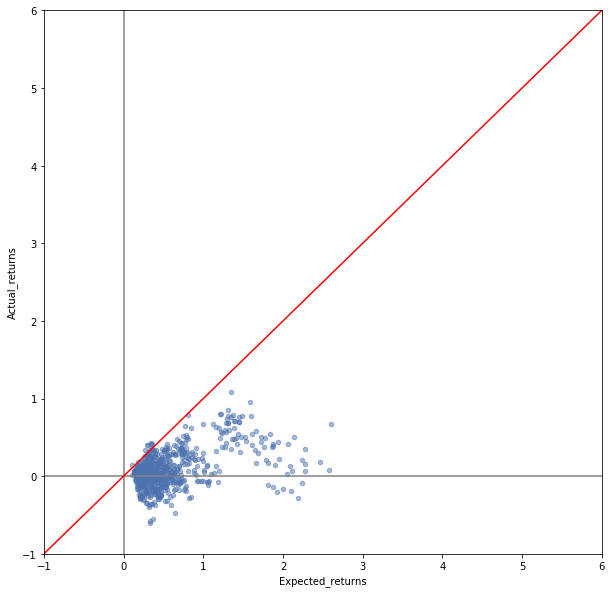

In [36]:
# Plot expected vs actual scatter
import matplotlib.lines as mlines
ax1 = df_test.plot.scatter(x='Expected_returns', y='Actual_returns',alpha=0.5)

#set the x=y line
line = mlines.Line2D([0, 1], [0, 1], color='red')

#draw axis lines
plt.axhline(0,color='gray') # x = 0
plt.axvline(0,color='gray') # y = 0
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)
ax1.set_xlim([-1, 6])
ax1.set_ylim([-1, 6])

0.5930507370583157

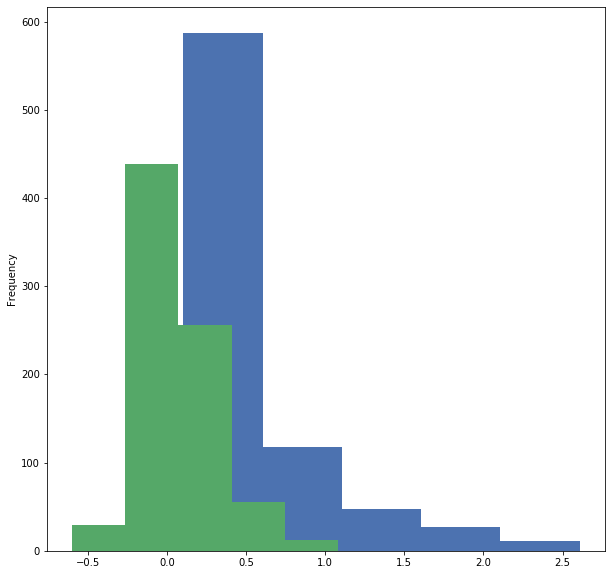

In [37]:
#plot epected vs actual returns
df_test.Expected_returns.plot.hist(bins=5)
df_test.Actual_returns.plot.hist(bins=5)



from sklearn.metrics import mean_squared_error
mean_squared_error(df_test.Actual_returns, df_test.Expected_returns, squared=False)

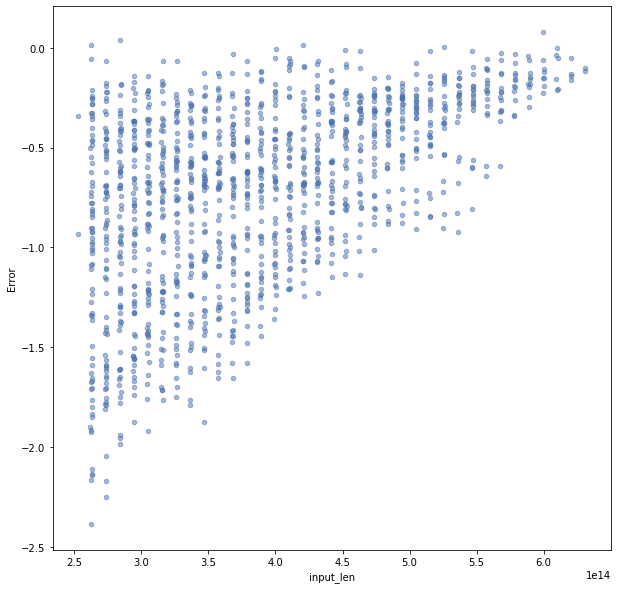

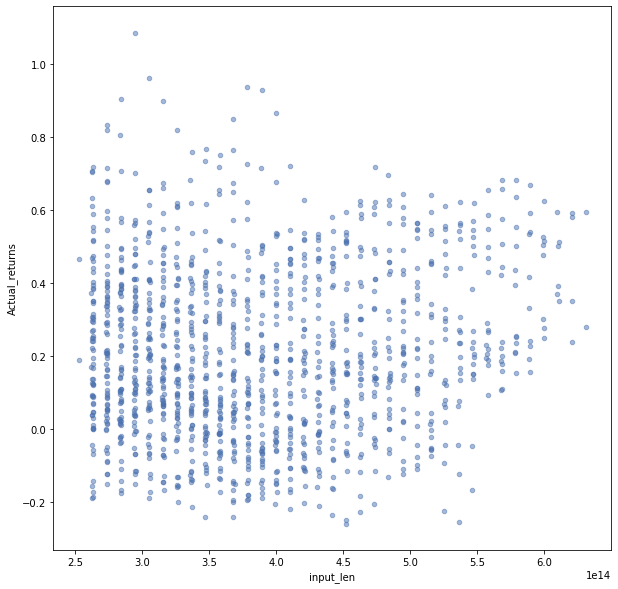

In [66]:
df_test['Error']=df_test.Actual_returns - df_test.Expected_returns 
df_test['input_len']=pd.to_numeric(df_test['End_date'] - df_test['Start_Date'])/250 #in years need to fix  this its in seconds or something
# Plot expected vs actual scatter
import matplotlib.lines as mlines
ax1 = df_test.plot.scatter(x='input_len', y='Error',alpha=0.5)
plt.show()
#ax1 = df_test.plot.scatter(x='input_len', y='Expected_returns',alpha=0.5)
#ax1 = df_test.plot.scatter(x='input_len', y='Actual_returns',alpha=0.5)
#ax1 = df_test.plot.scatter(x='starting_asset', y='Error',alpha=0.5)
#plt.show()
ax1 = df_test.plot.scatter(x='input_len', y='Actual_returns',alpha=0.5)
plt.show()

In [67]:
df_test

,Start_Date,End_date,Expected_returns,Actual_returns,starting_asset,Error,input_len
0,2015-01-01,2020-01-01,0.696954,0.595753,0,-0.101201,6.310656e+14
1,2015-02-01,2020-01-01,0.721162,0.581508,0,-0.139654,6.203520e+14
2,2015-03-01,2020-01-01,0.720837,0.513226,0,-0.207610,6.106752e+14
3,2015-04-01,2020-01-01,0.705726,0.516086,0,-0.189640,5.999616e+14
4,2015-05-01,2020-01-01,0.698451,0.540439,0,-0.158013,5.895936e+14
...,...,...,...,...,...,...,...
1329,2015-03-01,2017-04-01,0.534046,0.048459,50,-0.485586,2.633472e+14
1330,2015-01-01,2017-03-01,0.529210,0.213230,50,-0.315981,2.730240e+14
1331,2015-02-01,2017-03-01,0.569074,0.241689,50,-0.327384,2.623104e+14
1332,2015-01-01,2017-02-01,0.533817,0.178335,50,-0.355482,2.633472e+14


# Get the discrete allocation of each share per stock notused
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

portfolio_val = 3000
latest_prices=get_latest_prices(df)
weights=cl_weights
da=DiscreteAllocation(weights,latest_prices,total_portfolio_value=portfolio_val)
allocation, leftover = da.lp_portfolio()

print('Discrete allocation  :', allocation)
print('Funds Remaining:', leftover)

In [80]:
df_analyse=df_test
df_analyse['Error']=df_analyse.Actual_returns - df_analyse.Expected_returns 
df_analyse['input_len']=np.round(df_analyse['input_len']/1.262e+14,2)
df_analyse.head()

,Start_Date,End_date,Expected_returns,Actual_returns,starting_asset,Error,input_len
0,2010-01-01,2020-01-01,0.346463,0.355084,0,0.008621,10.00
1,2010-02-01,2020-01-01,0.353383,0.396529,0,0.043146,9.92
2,2010-03-01,2020-01-01,0.349146,0.331604,0,-0.017542,9.84
3,2010-04-01,2020-01-01,0.353686,0.379931,0,0.026244,9.75
4,2010-05-01,2020-01-01,0.342047,0.378750,0,0.036703,9.67


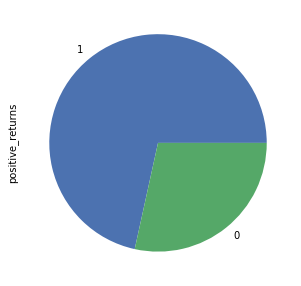

In [81]:
df_analyse['positive_returns']=(df_analyse.Actual_returns>0).astype(int)
df_analyse['positive_returns'].value_counts().plot.pie(figsize=(5, 5))

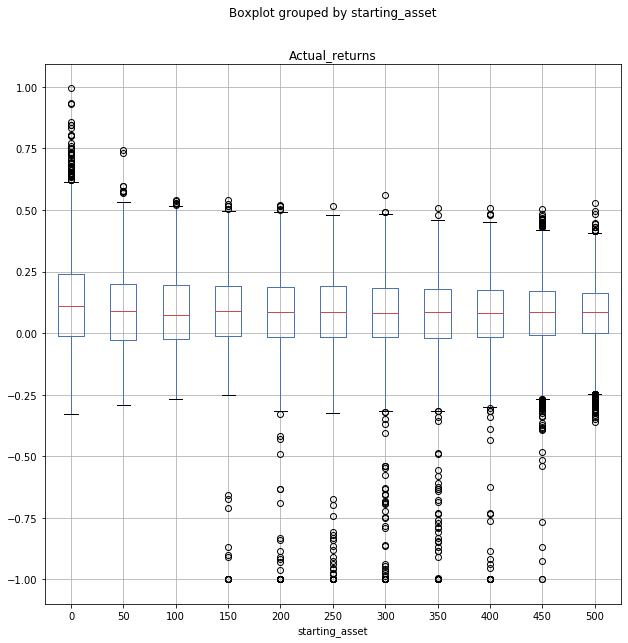

In [82]:
df_analyse.boxplot(column='Actual_returns', by='starting_asset')

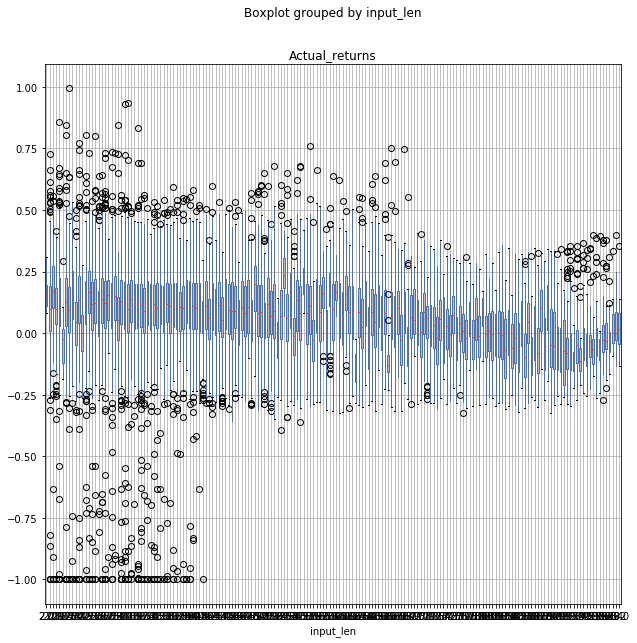

In [83]:
df_analyse.boxplot(column='Actual_returns', by='input_len')

In [84]:
df_analyse.to_csv('prt_Performance_data.csv')

In [85]:
df_analyse.head()

,Start_Date,End_date,Expected_returns,Actual_returns,starting_asset,Error,input_len,positive_returns
0,2010-01-01,2020-01-01,0.346463,0.355084,0,0.008621,10.00,1
1,2010-02-01,2020-01-01,0.353383,0.396529,0,0.043146,9.92,1
2,2010-03-01,2020-01-01,0.349146,0.331604,0,-0.017542,9.84,1
3,2010-04-01,2020-01-01,0.353686,0.379931,0,0.026244,9.75,1
4,2010-05-01,2020-01-01,0.342047,0.378750,0,0.036703,9.67,1


In [86]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_boston
from sklearn import tree

from dtreeviz.trees import *

[Text(279.0, 453.0, 'input_len <= 6.875\ngini = 0.408\nsamples = 40981\nvalue = [11693, 29288]\nclass = Positive'),
 Text(139.5, 271.8, 'input_len <= 4.54\ngini = 0.368\nsamples = 34424\nvalue = [8385, 26039]\nclass = Positive'),
 Text(69.75, 90.59999999999997, 'gini = 0.329\nsamples = 21480\nvalue = [4468, 17012]\nclass = Positive'),
 Text(209.25, 90.59999999999997, 'gini = 0.422\nsamples = 12944\nvalue = [3917, 9027]\nclass = Positive'),
 Text(418.5, 271.8, 'input_len <= 8.88\ngini = 0.5\nsamples = 6557\nvalue = [3308, 3249]\nclass = Negative'),
 Text(348.75, 90.59999999999997, 'gini = 0.499\nsamples = 5620\nvalue = [2658, 2962]\nclass = Positive'),
 Text(488.25, 90.59999999999997, 'gini = 0.425\nsamples = 937\nvalue = [650, 287]\nclass = Negative')]

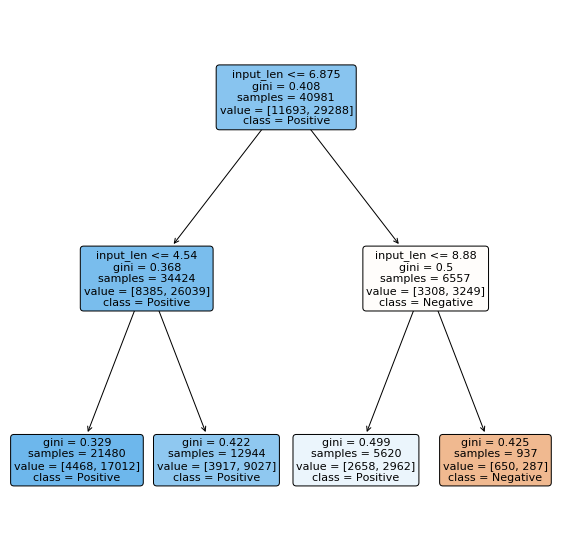

In [87]:
cols=['Expected_returns', 'starting_asset', 'input_len']
X = df_analyse[cols]
y = df_analyse['positive_returns']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit the classifier
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)

#Visualise
tree.plot_tree(clf,
               feature_names = ['Expected_returns', 'starting_asset', 'input_len'], 
               class_names=['Negative','Positive'],
               rounded=True, 
               filled = True)
